# An Attempt At A Bespoke Wave-U-Net for "Take on Me" Demixing

## Chris Tralie

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from scipy import signal
import librosa
import time
from scipy.io import wavfile
import glob
from torch.optim.lr_scheduler import StepLR

In [2]:
class AudioMix(Dataset):
    def __init__(self, folder, n_examples, clip_len, sr=16000):
        """
        Setup data of audio mixtures
        
        Parameters
        ----------
        folder: string
            Folder containing tracks
        n_examples: int
            Number of examples to create in a batch
        clip_len: float
            Length of a clip, in samples
        sr: int
            Sample rate
        """
        self.n_examples = n_examples
        self.clip_len = clip_len
        self.sr = sr
        files = glob.glob("{}/*.mp3".format(folder))
        self.x = []
        for f in files:
            xi, _ = librosa.load(f, sr=sr)
            self.x.append(xi)
    
    def __len__(self):
        return self.n_examples
    
    def __getitem__(self, idx):
        """
        S is "source", M is "mixture"
        """
        n_clips = len(self.x)
        mix = np.random.rand(n_clips)
        mix = mix/np.sum(mix)
        N = len(self.x[0])
        i1 = np.random.randint(N-self.clip_len)
        S = [np.array(mi*xi[i1:i1+self.clip_len], dtype=np.float32) for mi, xi in zip(mix, self.x)]
        M = np.zeros_like(S[0]) # Mixture audio
        for xi in S:
            M += xi
        S = torch.from_numpy(np.array(S, dtype=np.float32))
        M = torch.from_numpy(M[None, :])
        return M, S
        
data = AudioMix("Aha", 2000, 16384)
M, S = data[0]
print("S.shape", S.shape)
print("M.shape", M.shape)

S.shape torch.Size([8, 16384])
M.shape torch.Size([1, 16384])


In [3]:
loader = DataLoader(data, shuffle=True, batch_size=16)
M, S = next(iter(loader))
print(S.shape)
conv = nn.Conv1d(1, 24, 15, stride=1, padding=7, bias=False)
Mc = conv(M)
print(Mc.shape)

torch.Size([16, 8, 16384])
torch.Size([16, 24, 16384])


In [4]:
class Decimate(nn.Module):
    """
    Decimate by a factor of fac across the time axis (axis=1)
    """
    def __init__(self, fac):
        super(Decimate, self).__init__()
        self.fac = fac
    
    def forward(self, X):
        return X[:, :, 0::self.fac]

class WaveUNet(nn.Module):
    def __init__(self, C, L=12, Fc=24, fd=15, fu=5):
        """
        Parameters
        ----------
        C: int
            Number of mixture components
        L: int
            Number of layers
        Fc: int
            Number of extra filters per layer
        fd: int
            Kernel size for downsampling
        fu: int
            Kernel size for upsampling
        """
        super(WaveUNet, self).__init__()
        self.C = C
        
        ## Step 1: Create the convolutional down layers
        last_channels = 1
        channels = Fc
        down = []
        all_channels = [last_channels]
        for i in range(L+1):
            all_channels.append(channels)
            conv = nn.Conv1d(last_channels, channels, fd, stride=1, padding=fd//2, bias=False)
            last_channels = channels
            channels += Fc
            down.append(conv)
        self.down = nn.Sequential(*down)
        
        ## Step 2: Create the convolutional up layers
        up = []
        for i in range(L, 0, -1):
            convup = nn.Conv1d(all_channels[i+1]+all_channels[i], all_channels[i], fu, stride=1, padding=fu//2, bias=False)
            up.append(convup)
        self.up = nn.Sequential(*up)
        
        ## Step 3: Create the last layer
        self.final = nn.Conv1d(all_channels[1]+1, C-1, fu, stride=1, padding=fu//2, bias=False)
    
    def forward(self, M, verbose=False):
        relu = nn.LeakyReLU()
        downsample = Decimate(2)
        upsample = nn.Upsample(scale_factor=2, mode='linear')
        conv_outputs = []
        S = M
        for i, convdown in enumerate(self.down):
            S = convdown(S)
            if i < len(self.down)-1:
                conv_outputs.append(S) # Keep track of outputs for skip connections
                S = downsample(S)
            S = relu(S)
        conv_outputs.reverse()
            
        for i, convup in enumerate(self.up):
            S = upsample(S)
            S = torch.cat((S, conv_outputs[i]), dim=1) # Skip connections
            S = convup(S)
            S = relu(S)
        
        S = torch.cat((S, M), dim=1) # Final skip connection
        S = self.final(S)
        S = torch.tanh(S)
        # Enforce the condition that the sources sum to the mixture by making the last
        # component be the mixture minus the sum of the others
        S = torch.cat((S, M-torch.sum(S, dim=1, keepdims=True)), dim=1) 
        return S
    
model = WaveUNet(len(data.x))
S_est = model(M)
print(S_est.shape)

torch.Size([16, 8, 16384])


# Train Loop

In [5]:
# Try to use the GPU
device = 'cuda'

def get_data(path, sr=16000):
    # Test data
    M_test, sr = librosa.load(path, sr=sr)
    # Round down to nearest power of 2
    N = 2**int(np.floor(np.log2(M_test.size)))
    M_test = M_test[0:N]
    M_test = np.array(M_test[None, None, :], dtype=np.float32)
    M_test = torch.from_numpy(M_test).to(device)
    return M_test

M_test_real = get_data("TakeOnMe.mp3")
M_test = get_data("TakeOnMeMidiMix.mp3")

In [6]:
# Model
model = WaveUNet(len(data.x), L=11)
model = model.to(device)

## Step 3: Setup the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 200 # Each "epoch" is a loop through the entire dataset
# and we use this to update the parameters
train_losses = []

scheduler = StepLR(optimizer, step_size=20, gamma=0.9)

for epoch in range(n_epochs):
    loader = DataLoader(data, batch_size=16, shuffle=True)
    train_loss = 0
    for M, S in loader: # Go through each mini batch
        # Move inputs/outputs to GPU
        M = M.to(device)
        S = S.to(device)
        # Reset the optimizer's gradients
        optimizer.zero_grad()
        # Run the sequential model on all inputs
        S_est = model(M)
        # Compute the loss function comparing S_est to S
        loss = torch.sum((S_est - S)**2)
        # Compute the gradients of the loss function with respect
        # to all of the parameters of the model
        loss.backward()
        # Update the parameters based on the gradient and
        # the optimization scheme
        optimizer.step()
        train_loss += loss.item()
    
    print("Epoch {}, loss {:.3f}".format(epoch, train_loss))
    train_losses.append(train_loss)
    scheduler.step()
    
    S_test = model(M_test).detach().cpu().numpy()
    for i in range(S_test.shape[1]):
        s = S_test[0, i, :]
        s = np.array(s*32768/np.max(np.abs(s)), dtype=np.int16)
        wavfile.write("track{}.wav".format(i), 16000, s)
        
    S_test = model(M_test_real).detach().cpu().numpy()
    for i in range(S_test.shape[1]):
        s = S_test[0, i, :]
        s = np.array(s*32768/np.max(np.abs(s)), dtype=np.int16)
        wavfile.write("real_track{}.wav".format(i), 16000, s)
    

Epoch 0, loss 8784.955
Epoch 1, loss 6568.868
Epoch 2, loss 5773.718
Epoch 3, loss 5659.990
Epoch 4, loss 5310.520
Epoch 5, loss 4998.324
Epoch 6, loss 4733.059
Epoch 7, loss 4596.443
Epoch 8, loss 4400.862
Epoch 9, loss 4376.123
Epoch 10, loss 4256.050
Epoch 11, loss 4148.664
Epoch 12, loss 3935.325
Epoch 13, loss 3792.594
Epoch 14, loss 3697.154
Epoch 15, loss 3603.057
Epoch 16, loss 3455.174
Epoch 17, loss 3372.148
Epoch 18, loss 3363.085
Epoch 19, loss 3310.842
Epoch 20, loss 3123.296
Epoch 21, loss 3068.609
Epoch 22, loss 3050.648
Epoch 23, loss 2926.443
Epoch 24, loss 2962.861
Epoch 25, loss 2963.675
Epoch 26, loss 2860.648
Epoch 27, loss 2804.448
Epoch 28, loss 2803.535
Epoch 29, loss 2768.123
Epoch 30, loss 2773.792
Epoch 31, loss 2689.029
Epoch 32, loss 2673.193
Epoch 33, loss 2640.841
Epoch 34, loss 2619.100
Epoch 35, loss 2577.118
Epoch 36, loss 2599.381
Epoch 37, loss 2535.428
Epoch 38, loss 2471.429
Epoch 39, loss 2493.455
Epoch 40, loss 2455.474
Epoch 41, loss 2418.703
Ep

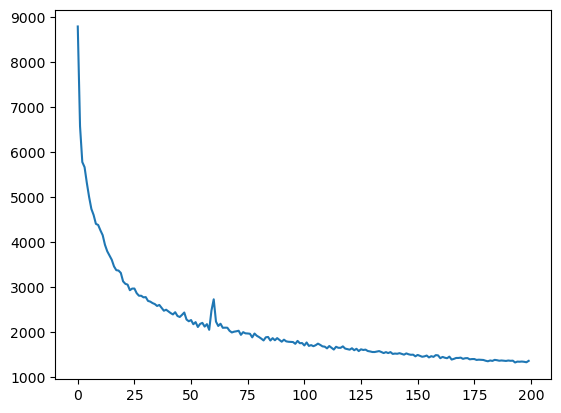

In [8]:
plt.plot(train_losses)